In [1]:
import os.path
import warnings

from Model.radiation.real_gas_data.hitran import LookupTableFolder
from Model.radiation.real_gas_data.specific_humidity import p_altitude_convert
from centa_presentation.base import get_olr_area

warnings.filterwarnings("ignore") # ignore all warnings in this notebook
import matplotlib.pyplot as plt
from Model.radiation.base import round_any
import Model.radiation.real_gas_data.hitran as hitran
import Model.radiation.real_gas_data.specific_humidity as humidity
from Model.radiation.real_gas_data.temperature_profiles import earth_temp, fixed_tropopause_temp, two_lapse_temp
from Model.radiation.real_gas import RealGas, transmission, B_wavenumber, optical_depth, sigma
from IPython.display import HTML
import numpy as np
import os
from tqdm.notebook import tqdm
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
import sys
sys.path.append('/Users/joshduffield/Documents/StAndrews/Isca/')
from isca_tools.plot import label_subplots, fig_resize, update_linewidth, update_fontsize, savefig

/Users/joshduffield/miniforge3/envs/ClimateModel/lib/python3.8/site-packages/sympl/_core/dataarray.py:6: FutureWarning: xarray subclass DataArray should explicitly define __slots__
  class DataArray(xr.DataArray):


### Gray gas absorption coefficient
The absorption coefficient of a gray gas is $\kappa=1$ at all wavenumbers as indicated below.

gray file exists


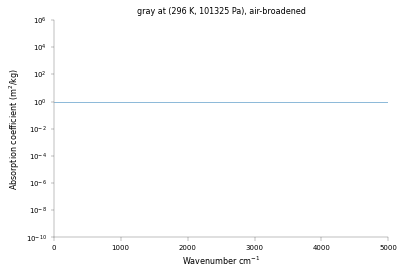

In [2]:
if os.path.isfile(LookupTableFolder + 'gray.npy'):
    print('gray file exists')
    hitran.plot_absorption_coefficient('gray', hitran.p_reference, 270)
else:
    # Just edit single line molecule, but make 1 everywhere
    sing_line_lookup = np.load(f'{LookupTableFolder}/single_line.npy',
                               allow_pickle=True).item();
    # sing_line_lookup['absorption_coef'] *= 0
    # sing_line_lookup['absorption_coef'] += 1
    sing_line_lookup['nu'] = np.arange(0, 5000+hitran.table_dnu, hitran.table_dnu)
    sing_line_lookup['absorption_coef'] = np.ones((1, 1, sing_line_lookup['nu'].size))
    np.save(LookupTableFolder + 'gray.npy', sing_line_lookup)

In [3]:
p_toa = 10  # Top of atmosphere pressure for this notebook (Pa)
n_bands = 200 # number of wavenumber bands in this notebook

In [4]:
# plotting info
lw_large = 1.8
im_width = 6.4

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

leg_info = {'handlelength': 3.5, 'labelspacing': 1, 'columnspacing': 0.9, 'handletextpad': 1}       # info for legend
def add_legend(ax, handles=None, labels=None, ncol=1, title=None, loc=None, frameon=False, edgecolor="k", borderpad=None,
               labelspacing=leg_info['labelspacing'], handlelength=leg_info['handlelength'],
               columnspacing=leg_info['columnspacing'], handletextpad=leg_info['handletextpad']):
    if handles is None:
        return ax.legend(ncol=ncol, title=title, loc=loc, frameon=frameon, edgecolor=edgecolor, borderpad=None,
                 labelspacing=labelspacing, handlelength=handlelength,
                 columnspacing=columnspacing, handletextpad=handletextpad)
    else:
        return ax.legend(handles, labels, ncol=ncol, title=title, loc=loc, frameon=frameon, edgecolor=edgecolor, borderpad=None,
                         labelspacing=labelspacing, handlelength=handlelength,
                         columnspacing=columnspacing, handletextpad=handletextpad)

## Constant humidity throughout atmosphere

In [93]:
lapse_rate = 6 # lapse rate in kelvin per km (dry is 9.8)
lapse_strat_array = [lapse_rate, 0, -lapse_rate]
lapse_strat = lapse_strat_array[0]
h_tropopause = 12 # height of tropopause in km
h_top = 20
temp_surf = 290 # temperature of surface in K
temp_tropopause = temp_surf - lapse_rate * h_tropopause
# temp_profile_use = lambda x: fixed_tropopause_temp(x, h_tropopause, temp_tropopause, temp_surf)
def temp_profile_use(x, y=lapse_strat):
    return two_lapse_temp(x, h_tropopause, h_top, temp_surf, lapse_rate, y)
# def temp_profile_use(x):
#     var = fixed_tropopause_temp(x, h_tropopause, temp_tropopause, temp_surf)
#     var[var<= temp_tropopause] = temp_surf
#     return var

In [94]:
gray_atmos = RealGas(nz='auto', ny=1, molecule_names=['gray'], p_toa=p_toa,
                            q_funcs={'gray': humidity.constant_q}, q_funcs_args={'gray': (300,'co2')},
                            T_func=temp_profile_use, n_nu_bands=n_bands)


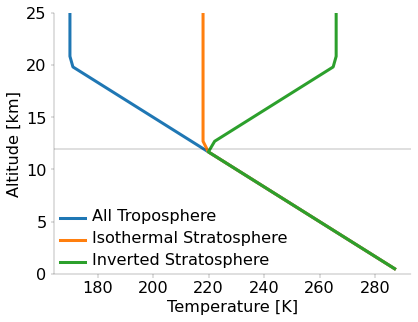

In [95]:
fig, ax = plt.subplots(1, 1)
labels_use = ['All Troposphere', 'Isothermal Stratosphere', 'Inverted Stratosphere']
fig_resize(fig, im_width)
for i in range(len(lapse_strat_array)):
    ax.plot(temp_profile_use(gray_atmos.p, lapse_strat_array[i]), p_altitude_convert(p=gray_atmos.p)/1000, label=labels_use[i])
# ax.invert_yaxis()
ax.set_ylim(0, 25)
update_linewidth(fig, base_linewidth=1.5)
ax.axhline(h_tropopause, color='k', lw=ax_linewidth)
add_legend(ax)
update_fontsize(fig)
ax.set_xlabel('Temperature [K]')
ax.set_ylabel('Altitude [km]')
plt.show()
# savefig(fig)

In [96]:
co2_conc = np.arange(0, 1000, 50)
co2_conc[0] = 1   # otherwise get 0 error
n_conc = co2_conc.size
olr_breakdown = {key: np.zeros(n_conc) for key in ['all', 'surface', 'atmos']}
for i in tqdm(range(n_conc)):
    gray_atmos = RealGas(nz='auto', ny=1, molecule_names=['gray'], p_toa=p_toa,
                                q_funcs={'gray': humidity.constant_q}, q_funcs_args={'gray': (co2_conc[i],'co2')},
                                T_func=temp_profile_use, n_nu_bands=n_bands)
    olr_breakdown['all'][i] = get_olr_area(gray_atmos)
    var = gray_atmos.get_flux(include_olr_breakdown=True)[2]
    olr_breakdown['surface'][i] = get_olr_area(gray_atmos, flux=var['surface'])
olr_breakdown['atmos'] = olr_breakdown['all'] - olr_breakdown['surface']
olr_tropopause = get_olr_area(gray_atmos, flux=B_wavenumber(gray_atmos.nu_bands['centre'], temp_tropopause)*np.pi)

  0%|          | 0/20 [00:00<?, ?it/s]

In [97]:
linestyle_olr = {'all': '-', 'surface': '--', 'atmos': ':'}
label_olr = {'all': 'Total', 'surface': 'Surface', 'atmos': 'Atmosphere'}

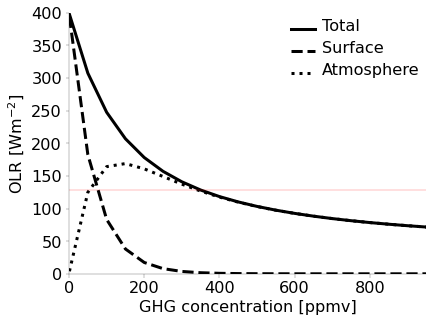

In [98]:
fig, ax = plt.subplots(1, 1)
fig_resize(fig, im_width)
for key in olr_breakdown:
    ax.plot(co2_conc, olr_breakdown[key], color='k', linestyle=linestyle_olr[key], label=label_olr[key])
# ax.plot(co2_conc, olr_breakdown['atmos'])

update_linewidth(fig, base_linewidth=1.5)
ax.axhline(olr_tropopause, color='r', lw=ax_linewidth)
add_legend(ax)
update_fontsize(fig)
ax.set_xlabel('GHG concentration [ppmv]')
ax.set_ylabel('OLR [Wm$^{-2}$]')
ax.set_xlim(0, co2_conc[-1])
ax.set_ylim(0, 400)
plt.show()
savefig(fig)

### Peak at surface

In [79]:
if lapse_strat != 0:
    raise ValueError('The below stuff is only for lase_strat=0')

In [80]:
olr_breakdown_sfc = {key: np.zeros(n_conc) for key in ['all', 'surface', 'atmos']}
for i in tqdm(range(n_conc)):
    gray_atmos = RealGas(nz='auto', ny=1, molecule_names=['gray'], p_toa=p_toa,
                            q_funcs={'gray': humidity.gradient_q}, q_funcs_args={'gray': (co2_conc[i], 0, h_tropopause*1000, 'co2')},
                            T_func=temp_profile_use, n_nu_bands=n_bands)
    olr_breakdown_sfc['all'][i] = get_olr_area(gray_atmos)
    var = gray_atmos.get_flux(include_olr_breakdown=True)[2]
    olr_breakdown_sfc['surface'][i] = get_olr_area(gray_atmos, flux=var['surface'])
olr_breakdown_sfc['atmos'] = olr_breakdown_sfc['all'] - olr_breakdown_sfc['surface']

  0%|          | 0/20 [00:00<?, ?it/s]

In [81]:
olr_breakdown_atm = {key: np.zeros(n_conc) for key in ['all', 'surface', 'atmos']}
for i in tqdm(range(n_conc)):
    gray_atmos = RealGas(nz='auto', ny=1, molecule_names=['gray'], p_toa=p_toa,
                            q_funcs={'gray': humidity.gradient_q}, q_funcs_args={'gray': (0, co2_conc[i], h_tropopause*1000, 'co2')},
                            T_func=temp_profile_use, n_nu_bands=n_bands)
    olr_breakdown_atm['all'][i] = get_olr_area(gray_atmos)
    var = gray_atmos.get_flux(include_olr_breakdown=True)[2]
    olr_breakdown_atm['surface'][i] = get_olr_area(gray_atmos, flux=var['surface'])
olr_breakdown_atm['atmos'] = olr_breakdown_atm['all'] - olr_breakdown_atm['surface']

  0%|          | 0/20 [00:00<?, ?it/s]

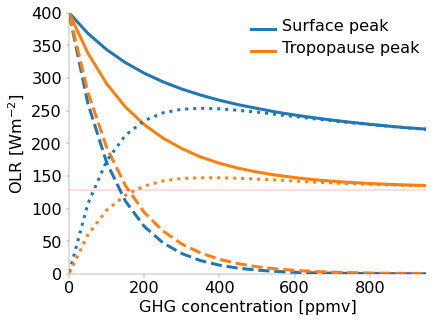

In [84]:
fig, ax = plt.subplots(1, 1)
fig_resize(fig, im_width)
for key in olr_breakdown_sfc:
    ax.plot(co2_conc, olr_breakdown_sfc[key], color=default_colors[0], linestyle=linestyle_olr[key], label='Surface peak' if key=='all' else None)
    ax.plot(co2_conc, olr_breakdown_atm[key], color=default_colors[1], linestyle=linestyle_olr[key], label='Tropopause peak' if key=='all' else None)
# ax.plot(co2_conc, olr_breakdown['atmos'])

update_linewidth(fig, base_linewidth=1.5)
ax.axhline(olr_tropopause, color='r', lw=ax_linewidth)
add_legend(ax)
update_fontsize(fig)
ax.set_xlabel('GHG concentration [ppmv]')
ax.set_ylabel('OLR [Wm$^{-2}$]')
ax.set_xlim(0, co2_conc[-1])
ax.set_ylim(0, 400)
plt.show()
# savefig(fig)

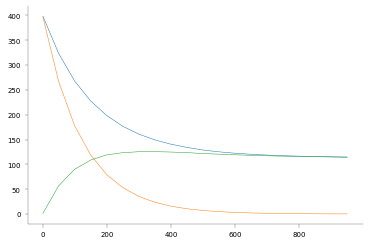

In [17]:
plt.plot(co2_conc, olr_breakdown_atm['all'])
plt.plot(co2_conc, olr_breakdown_atm['surface'])
plt.plot(co2_conc, olr_breakdown_atm['atmos'])

In [18]:
gray_atmos = RealGas(nz='auto', ny=1, molecule_names=['gray'], p_toa=p_toa,
                            q_funcs={'gray': humidity.gradient_q}, q_funcs_args={'gray': (co2_conc[i], 0, 19*1000)},
                            T_func=fixed_tropopause_temp, n_nu_bands=n_bands)

In [19]:
gray_atmos = RealGas(nz='auto', ny=1, molecule_names=['gray'], p_toa=p_toa,
                            q_funcs={'gray': humidity.constant_rh}, q_funcs_args={'gray': (fixed_tropopause_temp, 0.7, 19*1000, 'h2o')},
                            T_func=fixed_tropopause_temp, n_nu_bands=n_bands)

In [20]:
def plot_T_q_OLR(atmos, log_q=True):
    fig, axs = plt.subplots(1,3, figsize=(18,6))
    axs[0].get_shared_y_axes().join(axs[0], axs[1])
    axs[0].plot(atmos.T, atmos.p)
    axs[0].axes.invert_yaxis()
    axs[0].set_yscale('log')
    axs[0].set_ylabel('Pressure / Pa')
    axs[0].set_xlabel('Temperature / K')
    for molecule_name in atmos.molecule_names:
        if molecule_name == 'gray':
            M_name = 'CO2'
        else:
            M_name = molecule_name
        axs[1].plot(humidity.ppmv_from_humidity(
                    atmos.q_funcs[molecule_name](atmos.p, *atmos.q_funcs_args[molecule_name]), M_name),
                    atmos.p, label=molecule_name)
    if log_q:
        axs[1].set_xscale('log')
    axs[1].set_xlabel('Volume Mixing Ratio (ppmv)')
    axs[1].legend()
    atmos.plot_olr(ax=axs[2])
    return fig, axs

(0.0, 6000.0)

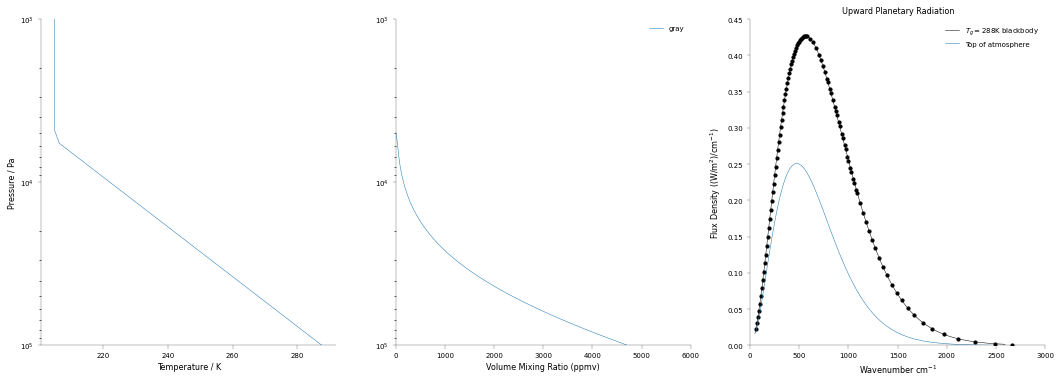

In [21]:
fig, ax = plot_T_q_OLR(gray_atmos, log_q=False)
ax[0].set_ylim(10**5, 10**3)
ax[1].set_xlim(0, 6000)

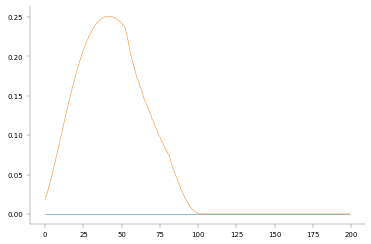

In [22]:
plt.plot(gray_atmos.get_flux(True)[2]['surface'])
plt.plot(gray_atmos.get_flux(True)[2]['atmos'])
# plt.plot(gray_atmos.up_flux[0])